# Анализ оттока клиентов телеком компании

In [1]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

### 1. Изучение данных

In [2]:
data_contract = pd.read_csv('/datasets/final_provider/contract.csv')
data_personal = pd.read_csv('/datasets/final_provider/personal.csv')
data_internet = pd.read_csv('/datasets/final_provider/internet.csv')
data_phone = pd.read_csv('/datasets/final_provider/phone.csv')
data_contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [3]:
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Датасет *data_contract* содержит записи о 7043 клиентах, которые пользуются услугами оператора *«Ниединогоразрыва.ком»*, их идентификатор, дату начала и окончания договора, платетежная информация. Пропусков нет.

In [4]:
data_personal

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [5]:
data_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Датасет *data_personal* содержит социальную информацию о тех же клиентах - пол, является ли пенсионером, состоит ли в браке, информация о наличии детей. Пропусков нет.

In [6]:
data_internet

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [7]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


Датасет *data_internet* содержит информацию о 5517 клиентах, которые используют интрент или какие-нибудь другие опциональные пакеты, например, антивирусая программа или потоковое телевидение. Пропусков нет.

In [8]:
data_phone

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [9]:
data_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


Датасет *data_phone* содержит информация о 6361 клиентах, которые используют или не используют режим многоканальной связи по телефону. Пропусков нет.

### 2. Объединение данных

Все четыре датасета объединяет столбец, содержащий идентификатор пользователя *customerID*, по нему и будем производить объединение методом *merge()*

In [10]:
data = data_contract.merge(data_personal, on='customerID', how='left'
                          ).merge(data_internet, on='customerID', how='left'
                                 ).merge(data_phone, on='customerID', how='left')

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
MultipleLines       6361 non-null object
dtypes: float64(1), int64(1), object(18)
memory usage: 1.1+ MB


Получили полный датасет, содержащий информацию о всех 7043 клиентах. Те датасеты, которые были изначально неполными по своим столбцам сформировали пропуски, которые в дальнейшем необходимо заполнить. Так, колонки *OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines* содержат информацию о том, пользуются ли клиент этой услугой. Предположим, что если информации не содержится, то клиент не являлся и не является пользователем этой услуги, соответственно недостающие значения следует заменить словом *No*. Пропуски в столбце *InternetService* заменим на 0 в связи с тем, что данные не установлены и их не вывести из существующих признаков, предположим, что клиент так же не пользуется данными типами соединения.

Столбцы, содержащие конструкцию *Yes/No* или тип данных *object* заменим целочисленными значениями *1/0*.

### 3. Предобработка данных

Проверим наличие дубликатов в датасете:

In [13]:
data.duplicated().sum()

0

Для того, чтобы понимать как заменить имеющиеся в столбце *TotalCharges* пробелы (пропуски), построим фрейм содержащий информацию только об этих пользователях.

In [14]:
who_data = data.loc[data['TotalCharges'] == ' ']
who_data

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


Как видим, абоненты с пробелами в столбце *TotalCharges* имеют единую дату подключения к оператору - 1 февраля 2020 года, что является датой выгрузки датасета. Логично, что эти абоненты еще не заплатили (на момент выгрузки) абонентскую плату, в этой связи пропуски в этом столбце заменим на *0*.

In [15]:
data['TotalCharges'] = data['TotalCharges'].replace(to_replace =' ', value = 0, regex = True)
data = data.astype({"BeginDate":'datetime64', "TotalCharges":'float64'})

data['OnlineSecurity'] = data['OnlineSecurity'].fillna('No')
data['OnlineBackup'] = data['OnlineBackup'].fillna('No')
data['DeviceProtection'] = data['DeviceProtection'].fillna('No')
data['TechSupport'] = data['TechSupport'].fillna('No')
data['StreamingTV'] = data['StreamingTV'].fillna('No')
data['StreamingMovies'] = data['StreamingMovies'].fillna('No')
data['MultipleLines'] = data['MultipleLines'].fillna('No')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
customerID          7043 non-null object
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     5517 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
MultipleLines       7043 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(16)
memo

Избавились от пропусков в данных. Установим *customerID* в качестве индекса датасета и произведем замену типа данных *object* на целочисленный:

In [16]:
data = data.set_index('customerID')
data['PaperlessBilling'] = pd.get_dummies(data['PaperlessBilling'], drop_first=True)
data['gender'] = pd.get_dummies(data['gender'], drop_first=True)
data['Partner'] = pd.get_dummies(data['Partner'], drop_first=True)
data['Dependents'] = pd.get_dummies(data['Dependents'], drop_first=True)
data['OnlineSecurity'] = pd.get_dummies(data['OnlineSecurity'], drop_first=True)
data['OnlineBackup'] = pd.get_dummies(data['OnlineBackup'], drop_first=True)
data['DeviceProtection'] = pd.get_dummies(data['DeviceProtection'], drop_first=True)
data['TechSupport'] = pd.get_dummies(data['TechSupport'], drop_first=True)
data['StreamingTV'] = pd.get_dummies(data['StreamingTV'], drop_first=True)
data['StreamingMovies'] = pd.get_dummies(data['StreamingMovies'], drop_first=True)
data['MultipleLines'] = pd.get_dummies(data['MultipleLines'], drop_first=True)

На основе информации содержащейся в столбце *EndDate* сгенерируем столбец *Left*, который будет содержать информацию о том, перестал ли клиент пользоваться услугами оператора. Так как данные выгружены на 01 февраля 2020 года, то в столбце *EndDate* заменим значения *No* на эту дату, чтобы найти время пользования клиентом услугами оператора связи *LifeTimeDays* (в днях). Затем удалим столбцы с первичными данным - *BeginDate* и *EndDate*.

In [17]:
def left(column):
    if column == 'No':
        return 0
    else:
        return 1

data['Left'] = data['EndDate'].apply(left)

def lt(column):
    if column == 'No':
        return '2020-02-01 00:00:00'
    else:
        return column
    
data['EndDate'] = data['EndDate'].apply(lt)
data = data.astype({"EndDate":'datetime64'})

data = data.assign(
    LifeTimeDays=
    (data['EndDate'] - data['BeginDate']).dt.days)

del data['BeginDate']
del data['EndDate']

In [18]:
data

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Left,LifeTimeDays
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,1,Electronic check,29.85,29.85,0,0,1,0,DSL,0,1,0,0,0,0,0,0,31
5575-GNVDE,One year,0,Mailed check,56.95,1889.50,1,0,0,0,DSL,1,0,1,0,0,0,0,0,1036
3668-QPYBK,Month-to-month,1,Mailed check,53.85,108.15,1,0,0,0,DSL,1,1,0,0,0,0,0,1,61
7795-CFOCW,One year,0,Bank transfer (automatic),42.30,1840.75,1,0,0,0,DSL,1,0,1,1,0,0,0,0,1371
9237-HQITU,Month-to-month,1,Electronic check,70.70,151.65,0,0,0,0,Fiber optic,0,0,0,0,0,0,0,1,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,One year,1,Mailed check,84.80,1990.50,1,0,1,1,DSL,1,0,1,1,1,1,1,0,730
2234-XADUH,One year,1,Credit card (automatic),103.20,7362.90,0,0,1,1,Fiber optic,0,1,1,0,1,1,1,0,2191
4801-JZAZL,Month-to-month,1,Electronic check,29.60,346.45,0,0,1,1,DSL,1,0,0,0,0,0,0,0,337


Заменим оставшиеся категоральные переменные в индикаторные методом *get_dummies*, удаляя первый столбец (избегая дамми-ловушки):

In [19]:
data = pd.get_dummies(data, drop_first=True)

In [20]:
data

,PaperlessBilling,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,...,StreamingMovies,MultipleLines,Left,LifeTimeDays,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,1,29.85,29.85,0,0,1,0,0,1,0,...,0,0,0,31,0,0,0,1,0,0
5575-GNVDE,0,56.95,1889.50,1,0,0,0,1,0,1,...,0,0,0,1036,1,0,0,0,1,0
3668-QPYBK,1,53.85,108.15,1,0,0,0,1,1,0,...,0,0,1,61,0,0,0,0,1,0
7795-CFOCW,0,42.30,1840.75,1,0,0,0,1,0,1,...,0,0,0,1371,1,0,0,0,0,0
9237-HQITU,1,70.70,151.65,0,0,0,0,0,0,0,...,0,0,1,61,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,1,84.80,1990.50,1,0,1,1,1,0,1,...,1,1,0,730,1,0,0,0,1,0
2234-XADUH,1,103.20,7362.90,0,0,1,1,0,1,1,...,1,1,0,2191,1,0,1,0,0,1
4801-JZAZL,1,29.60,346.45,0,0,1,1,1,0,0,...,0,0,0,337,0,0,0,1,0,0


В столбцах *MonthlyCharges, TotalCharges, LifeTimeDays* присутствуют колличественные признаки с разными разбросами значений, алгорим может решить, что признаки с большими значениями и разбросом важнее. Чтобы избежать этой ловушки, масштабируем признаки — приведем их к одному масштабу.

In [21]:
numeric = ['MonthlyCharges', 'TotalCharges', 'LifeTimeDays']

scaler = StandardScaler()
scaler.fit(data[numeric])
data[numeric] = scaler.transform(data[numeric])

In [22]:
data

,PaperlessBilling,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,...,StreamingMovies,MultipleLines,Left,LifeTimeDays,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,1,-1.160323,-0.992611,0,0,1,0,0,1,0,...,0,0,0,-1.277527,0,0,0,1,0,0
5575-GNVDE,0,-0.259629,-0.172165,1,0,0,0,1,0,1,...,0,0,0,0.066892,1,0,0,0,1,0
3668-QPYBK,1,-0.362660,-0.958066,1,0,0,0,1,1,0,...,0,0,1,-1.237396,0,0,0,0,1,0
7795-CFOCW,0,-0.746535,-0.193672,1,0,0,0,1,0,1,...,0,0,0,0.515031,1,0,0,0,0,0
9237-HQITU,1,0.197365,-0.938874,0,0,0,0,0,0,0,...,0,0,1,-1.237396,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,1,0.665992,-0.127605,1,0,1,1,1,0,1,...,1,1,0,-0.342454,1,0,0,0,1,0
2234-XADUH,1,1.277533,2.242606,0,0,1,1,0,1,1,...,1,1,0,1.611970,1,0,1,0,0,1
4801-JZAZL,1,-1.168632,-0.852932,0,0,1,1,1,0,0,...,0,0,0,-0.868182,0,0,0,1,0,0


Заменили в датасете имевшиеся пропуски и некорректный тип данных, избавились от категоральных признаков, масштабировали количественные признаки с разным разбросом. Датасет готов к делению на выборки и поиску лучшей модели.

### 4. Деление данных на выборки

Разделим исходные данные на на выборки в следующем процентном соотношении:
* data_train - обучающая выборка (70%)
* data_test - тестовая выборка (15%)
* data_valid - валидационная аыборка (15%)

Использовали модель для деления 14:3:3 так как, помимо валидационной выборки выделяем так же тестовую выборку (равную ей) для дальнейшего тестирования поведения модели.

In [23]:
data_train, data_test_valid = train_test_split(data, test_size=0.3, random_state=12345)
data_test, data_valid = train_test_split(data_test_valid, test_size=0.5, random_state=12345)

Сохраненим признаки в отдельных переменных: features - все признаки, кроме целевого признака (факт ухода клиента из «Ниединогоразрыва.ком»), target — целевой признак, столбец Left (где 1 - клиент покинул оператора, 0 - остался его клиентом).

In [24]:
features_train = data_train.drop(columns=['Left'], axis=1)
target_train = data_train['Left']

features_valid = data_valid.drop(columns=['Left'], axis=1)
target_valid = data_valid['Left']

features_test = data_test.drop(columns=['Left'], axis=1)
target_test = data_test['Left']

### 5. Подбор модели

При выборе лучшей модели будем опираться на AUC-ROC метрику качества классификации, показывающую площадь под кривой ошибок, а так же accuracy - показывающую долю правильных ответов алгоритма.

#### LogisticRegression

In [25]:
param_grid_LR = {'C': [0.1, 0.5, 1, 5, 10, 50]}

grid_LR = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid_LR, cv=5, scoring="roc_auc") 
grid_LR.fit(features_train, target_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 0.5, 1, 5, 10, 50]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [26]:
grid_LR.best_score_

0.843853462422926

In [27]:
grid_LR.best_params_

{'C': 1}

In [28]:
probabilities_valid = grid_LR.best_estimator_.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
pred_valid = grid_LR.best_estimator_.predict(features_valid)

print("Roc-auc score (valid): {:.2f}".format(roc_auc_score(target_valid, probabilities_one_valid)))
print("Accuracy score (valid): {:.2f}".format(accuracy_score(target_valid, pred_valid)))

Roc-auc score (valid): 0.83
Accuracy score (valid): 0.77


#### RandomForestClassifier

In [29]:
param_grid_RFC = {
    'n_estimators': [350, 400, 450],
    'max_depth': [8, 9, 10],
    'random_state': [12345]}

grid_RFC = GridSearchCV(RandomForestClassifier(n_jobs=-1), param_grid_RFC, cv=5, scoring="roc_auc")
grid_RFC.fit(features_train, target_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=-1,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='

In [30]:
grid_RFC.best_score_

0.8596320627957491

In [31]:
grid_RFC.best_params_

{'max_depth': 8, 'n_estimators': 400, 'random_state': 12345}

In [32]:
probabilities_valid = grid_RFC.best_estimator_.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
pred_valid = grid_RFC.best_estimator_.predict(features_valid)

print("Roc-auc score (valid): {:.2f}".format(roc_auc_score(target_valid, probabilities_one_valid)))
print("Accuracy score (valid): {:.2f}".format(accuracy_score(target_valid, pred_valid)))

Roc-auc score (valid): 0.85
Accuracy score (valid): 0.79


#### CatBoostClassifier

In [33]:
cv = KFold(5, shuffle=True, random_state=12345)
CatBoost = CatBoostClassifier(random_seed = 12345, iterations = 100)

param_grid_CatBoost = {
    'learning_rate': np.logspace(-3, 0, 5),
    'depth': [2, 4, 6, 8]}

grid_CatBoost = GridSearchCV(CatBoost,
                        param_grid_CatBoost,
                        cv=cv,
                        scoring='roc_auc',
                        verbose=True)

grid_CatBoost.fit(features_train, target_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 0.6925786	total: 50.6ms	remaining: 5s
1:	learn: 0.6919934	total: 52.8ms	remaining: 2.58s
2:	learn: 0.6914553	total: 54.8ms	remaining: 1.77s
3:	learn: 0.6909902	total: 56.8ms	remaining: 1.36s
4:	learn: 0.6905062	total: 58.8ms	remaining: 1.12s
5:	learn: 0.6899367	total: 60.7ms	remaining: 952ms
6:	learn: 0.6893827	total: 62.9ms	remaining: 836ms
7:	learn: 0.6888434	total: 65.5ms	remaining: 753ms
8:	learn: 0.6882901	total: 67.6ms	remaining: 684ms
9:	learn: 0.6877378	total: 69.7ms	remaining: 627ms
10:	learn: 0.6871871	total: 108ms	remaining: 875ms
11:	learn: 0.6865993	total: 110ms	remaining: 808ms
12:	learn: 0.6860364	total: 112ms	remaining: 750ms
13:	learn: 0.6854773	total: 114ms	remaining: 701ms
14:	learn: 0.6849274	total: 116ms	remaining: 659ms
15:	learn: 0.6844277	total: 118ms	remaining: 621ms
16:	learn: 0.6839541	total: 120ms	remaining: 587ms
17:	learn: 0.6834379	total: 122ms	remaining: 557ms
18:	learn: 0.6829068	total: 124ms	remaining: 531ms
19:	learn: 0.6824580	total: 126ms	

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  5.3min finished


0:	learn: 0.4636728	total: 2.78ms	remaining: 275ms
1:	learn: 0.4409847	total: 5.26ms	remaining: 258ms
2:	learn: 0.4233741	total: 7.66ms	remaining: 248ms
3:	learn: 0.4114730	total: 10.3ms	remaining: 247ms
4:	learn: 0.4046693	total: 12.7ms	remaining: 241ms
5:	learn: 0.4016879	total: 15.1ms	remaining: 237ms
6:	learn: 0.3958571	total: 18.6ms	remaining: 248ms
7:	learn: 0.3922194	total: 22.5ms	remaining: 259ms
8:	learn: 0.3893512	total: 26.2ms	remaining: 265ms
9:	learn: 0.3870986	total: 28.7ms	remaining: 258ms
10:	learn: 0.3832157	total: 30.9ms	remaining: 250ms
11:	learn: 0.3757491	total: 108ms	remaining: 789ms
12:	learn: 0.3712014	total: 110ms	remaining: 737ms
13:	learn: 0.3660579	total: 113ms	remaining: 693ms
14:	learn: 0.3629565	total: 116ms	remaining: 658ms
15:	learn: 0.3595669	total: 119ms	remaining: 626ms
16:	learn: 0.3541913	total: 122ms	remaining: 594ms
17:	learn: 0.3525269	total: 124ms	remaining: 565ms
18:	learn: 0.3514024	total: 132ms	remaining: 561ms
19:	learn: 0.3498002	total: 20

GridSearchCV(cv=KFold(n_splits=5, random_state=12345, shuffle=True),
             error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostClassifier object at 0x7f9c40ceb790>,
             iid='warn', n_jobs=None,
             param_grid={'depth': [2, 4, 6, 8],
                         'learning_rate': array([0.001     , 0.00562341, 0.03162278, 0.17782794, 1.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=True)

In [34]:
grid_CatBoost.best_score_

0.9049656121610052

In [35]:
grid_CatBoost.best_params_

{'depth': 2, 'learning_rate': 1.0}

In [36]:
probabilities_valid = grid_CatBoost.best_estimator_.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
pred_valid = grid_CatBoost.best_estimator_.predict(features_valid)

print("Roc-auc score (valid): {:.2f}".format(roc_auc_score(target_valid, probabilities_one_valid)))
print("Accuracy score (valid): {:.2f}".format(accuracy_score(target_valid, pred_valid)))

Roc-auc score (valid): 0.89
Accuracy score (valid): 0.84


Лучшей моделью по метрике AUC-ROC при проверке на валидационной выборке является CatBoostClassifier с гиперпараметрами *depth = 2, learning_rate = 1.0* и *iterations = 100*, ее и будем проверять на тестовой. Значение метрики accuracy так же выше, чем на других моделях.

#### График важности признаков

In [37]:
CBC = CatBoostClassifier(random_seed = 12345, iterations = 100, depth = 2, learning_rate = 1.0)
model = CBC.fit(features_train, target_train)
feat_importances = pd.Series(model.feature_importances_, index=data.drop(columns=['Left'], axis=1).columns)

0:	learn: 0.4636728	total: 3ms	remaining: 298ms
1:	learn: 0.4409847	total: 6.79ms	remaining: 333ms
2:	learn: 0.4233741	total: 10.6ms	remaining: 342ms
3:	learn: 0.4114730	total: 14.4ms	remaining: 345ms
4:	learn: 0.4046693	total: 17.6ms	remaining: 335ms
5:	learn: 0.4016879	total: 21.5ms	remaining: 337ms
6:	learn: 0.3958571	total: 34ms	remaining: 452ms
7:	learn: 0.3922194	total: 36.6ms	remaining: 421ms
8:	learn: 0.3893512	total: 39ms	remaining: 394ms
9:	learn: 0.3870986	total: 42ms	remaining: 378ms
10:	learn: 0.3832157	total: 46.5ms	remaining: 376ms
11:	learn: 0.3757491	total: 51.7ms	remaining: 379ms
12:	learn: 0.3712014	total: 131ms	remaining: 877ms
13:	learn: 0.3660579	total: 134ms	remaining: 822ms
14:	learn: 0.3629565	total: 137ms	remaining: 776ms
15:	learn: 0.3595669	total: 139ms	remaining: 732ms
16:	learn: 0.3541913	total: 142ms	remaining: 694ms
17:	learn: 0.3525269	total: 144ms	remaining: 657ms
18:	learn: 0.3514024	total: 147ms	remaining: 625ms
19:	learn: 0.3498002	total: 150ms	rema

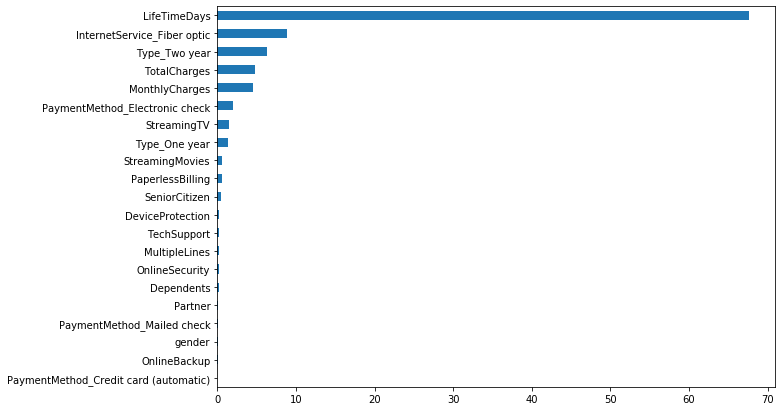

In [38]:
feat_importances.sort_values(ascending=True).plot(kind='barh', figsize=(10, 7))

Как видно из графика важности признаков, в первую очередь, работая с оттоком, необходимо учитывать время жизни клиента. Важность этого фактора превалирует над остальными показателями. Минимальную значимость имеют такие факторы как метод оплаты и наличие облачного хранилища файлов для резервного копирования данных.

### 6. Проверка на тестовой выборке

In [39]:
probabilities_test = grid_CatBoost.best_estimator_.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
pred_test = grid_CatBoost.best_estimator_.predict(features_test)

print("Roc-auc score (test): {:.2f}".format(roc_auc_score(target_test, probabilities_one_test)))
print("Accuracy score (test): {:.2f}".format(accuracy_score(target_test, pred_test)))

Roc-auc score (test): 0.90
Accuracy score (test): 0.86


### 7. Общий вывод 

По результатам анализа получили модель, которая будет предсказывать отток клиентов оператора связи «Ниединогоразрыва.ком», что позволит компании удержать этих клиентов, предложив им скидку на услуги. Следует обращать внимание на фактор времени жизни клиента как основной, по силе влияния, на отток абонентов для дальнейшей его минимизации.